## CS 6120: Natural Language Processing - Prof. Ahmad Uzair

### Assignment 2: Text Classification and Neural Network
### Total Points: 100 points

In Assignment 2, you will be dealing with text classification using Multinomial Naive Bayes and Neural Networks. You will also be dealing with vector visualization. In the previous assingment you implemented Bag of Words as the feature selection method. However, in this assignment you will be using TF-IDF Vectorization instead of Bag of Words. We recommend starting with this assignment a little early as the datasets are quite large and several parts of the assignment might take long duration to execute. 

## Question 1 Text Classification

In the first question you will be dealing with 20 News Group Dataset. You are required to implement TF-IDF vectorization from scratch and perform Multinomial Naive Bayes Classification on the News Group Dataset.
You may use appropriate packages or modules for fitting the Multinomial Naive Bayes Model, however, the implementation of the TF-IDF Vectorization should be from the scratch.

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date.

Link to the original dataset: http://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups

You can also import the dataset from sklearn.datasets

In [3]:
#importing the libraries

import numpy as np
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import pandas as pd
import re
import numpy as np
from nltk.tokenize import  word_tokenize
import nltk
from nltk.corpus import stopwords
import math
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup
from itertools import chain
nltk.download('punkt')
nltk.download('wordnet')
nltk.download("stopwords")
nltk.download('omw-1.4')

snowball = SnowballStemmer(language='english')

[nltk_data] Downloading package punkt to /Users/neo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/neo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/neo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/neo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [59]:
# Import the 20 news group dataset utilizing sklearn library

mydata_train = fetch_20newsgroups(subset='train')


mydata_test = fetch_20newsgroups(subset='test')



In [60]:
# Print the news groups(target) in the dataset

pprint(list(mydata_train.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [61]:
# What is the type of 'mydata_train' and 'mydata_test'

print(type(mydata_train))
print(type(mydata_test))

<class 'sklearn.utils._bunch.Bunch'>
<class 'sklearn.utils._bunch.Bunch'>


In [62]:
# Check the length of the data

print(len(mydata_train.data))
print(len(mydata_train.filenames))
print(len(mydata_test.data))
print(len(mydata_test.filenames))

11314
11314
7532
7532


### Expected Output: 
11314

11314

7532

7532

## Extracting Features from the Dataset                        (20 Points)

In order to perform machine learning on text documents, we first need to turn the text content into numerical feature vectors.

### TF-IDF Vectorization

Our model cannot simply read the text data so we convert it into numerical format. In order to convert the data into numerical format we create vectors from text.

For this particular purpose we could either employ Bag of Words or TF-IDF Vectorization

Bag of Words just creates a set of vectors containing the count of word occurrences in the document (reviews), while the TF-IDF model contains information on the more important words and the less important ones as well.

TF-IDF stands for Term Frequency-Inverse Document Frequency, which instead of giving more weight to words that occur more frequently, it gives a higher weight to words that occur less frequently.

Ref:https://www.analyticsvidhya.com/blog/2020/02/quick-introduction-bag-of-words-bow-tf-idf/#:~:text=Bag%20of%20Words%20just%20creates,less%20important%20ones%20as%20well.

TF-IDF = Term Frequency (TF) * Inverse Document Frequency (IDF)

Term Frequency is the measure of the frequency of words in a document. It is the ratio of the number of times the word appears in a document compared to the total number of words in that document.

The words that occur rarely in the corpus have a high IDF score. It is the log of the ratio of the number of documents to the number of documents containing the word.

idf(t) = log(N/(df + 1))

In [63]:
text = mydata_train.data
test = mydata_test.data
len(text)

11314

## Preprocessing the Corpus

In [83]:
# used stemming operation for text-preprocessing
def clean_review(review):
    no_html = BeautifulSoup(review).get_text()
    clean = re.sub("[^a-z\s]+", " ", no_html, flags=re.IGNORECASE)
    clean = re.sub("(\s+)", " ", clean)
#     clean = clean.lower()
#     stopwords_en = stopwords.words("english")
#     cleaned_stopwords = [w for w in re.split("\W+", clean) if not w in stopwords_en]
    cleaned_stopwords = clean.split()
    stemmed_words = []
    for w in cleaned_stopwords:
        stemmed_words.append(snowball.stem(w))
    return stemmed_words

In [96]:
# Preprocessing the data

lines = [] 
word_list = [] 

for sent in text:
    x = [i.lower() for  i in word_tokenize(sent) if i.isalpha()]
    lines.append(x)
    for word in x:
        if word not in word_list:
            word_list.append(word)
            
word_list = set(word_list)
total_documents = len(lines)

dict_idx = {} #Dictionary to store index for each word
i = 0
for word in word_list:
    dict_idx[word] = i
    i += 1


In [97]:
# Create a frequency dictionary
 
def frequency_dict(lines):
    '''
    lines: list containing all the tokens
    ---
    freq_word: returns a dictionary which keeps the count of the number of documents containing the given word
    '''

    freq_word = {}
    for word in word_list:
        freq_word[word] = 0
        for line in lines:
            if word in line:
                freq_word[word] += 1
    return freq_word
 

In [98]:
# Create a dictionary containing the frequency of words utilizing the 'frequency_dict' function

# Expect this chunk to take a comparatively longer time to execute since our dataset is large

freq_word = frequency_dict(lines)

freq_word

{'duckworth': 1,
 'srscnslt': 1,
 'sammons': 9,
 'actaual': 1,
 'circulation': 10,
 'ydvp': 1,
 'jab': 1,
 'transylvania': 1,
 'mwtilden': 1,
 'uaccess': 12,
 'privelege': 1,
 'etherlink': 1,
 'lauches': 1,
 'servo': 2,
 'millenia': 8,
 'lim': 15,
 'freeport': 2,
 'goudswaard': 3,
 'reinstate': 4,
 'evidentally': 1,
 'legged': 1,
 'cashed': 1,
 'mro': 1,
 'unfortunate': 42,
 'whitsell': 5,
 'extraction': 6,
 'dscy': 2,
 'retain': 29,
 'pencom': 1,
 'acceptably': 3,
 'averting': 1,
 'costello': 6,
 'cherbayev': 1,
 'zrcimrck': 1,
 'preparation': 20,
 'modalistic': 1,
 'cleaning': 44,
 'cjjj': 1,
 'ariane': 8,
 'portugal': 7,
 'floatingpoint': 1,
 'howe': 20,
 'mpoly': 2,
 'quibble': 11,
 'luftmeister': 1,
 'tennyson': 1,
 'instate': 2,
 'xws': 1,
 'weevils': 2,
 'wilhelm': 2,
 'xtndepth': 1,
 'ridiculed': 1,
 'marblehead': 1,
 'pleasant': 32,
 'thyssen': 1,
 'ujc': 1,
 'chartered': 2,
 'foolkiller': 2,
 'mbyets': 1,
 'hashemites': 1,
 'boone': 6,
 'hearts': 44,
 'slumping': 2,
 'gandalf

In [100]:
# Create a function to calculate the Term Frequency

def term_frequency(document, word):
    '''
    document: list containing the entire corpus
    word: word whose term frequency is to be calculated
    ---
    tf: returns term frequency value
    '''
    N = len(document)
    occurance = len([token for token in document if token == word])
    return occurance/N

In [105]:
# Create a function to calculate the Inverse Document Frequency
 
def inverse_df(word):
    '''
    word: word whose inverse document frequency is to be calculated
    ---
    idf: return inverse document frequency value
    '''

    try:
        word_occurance = freq_word[word] + 1
    except:
        word_occurance = 1
    return np.log(total_documents/word_occurance + 1)

In [106]:
#Create a function to combine the term frequencies (TF) and inverse document (IDF) frequencies calculated above to get TF-IDF

def tfidf(sentence,dict_idx):
    '''
    sentence: list containing the entire corpus
    dict: dictionary keeping track of index of each word
    ---
    tf_idf_vec: returns computed tf-idf
    '''

    tf_idf_vec = np.zeros((len(word_list),))
    for word in sentence:
        tf = term_frequency(sentence,word)
        idf = inverse_df(word)       
        value = tf*idf
        tf_idf_vec[dict_idx[word]] = value 
    return tf_idf_vec

In [107]:
#Compute the vectors utilizing the 'tfidf' function created above to obtain a TF-IDF Encoded text corpus
tf_idf_df = []
for each_text in lines:
    tf_idf_df.append (tfidf(each_text,dict_idx))
    
tf_idf_df = pd.DataFrame(tf_idf_df)

## Multinomial Naive Bayes (10 Points)

In [108]:
#Fit a Multinomial Naive Bayes Model on our dataset
print(tf_idf_df)
model = MultinomialNB().fit(tf_idf_df, mydata_train.target)

       0      1      2      3      4      5      6      7      8      9      \
0        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
11309    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
11310    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
11311    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
11312    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
11313    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

       ...  73233  73234  73235  73236  73237  7323

In [109]:
#Perform testing on the train dataset

pred = model.predict(tf_idf_df)
print(pred)

[7 4 4 ... 3 1 8]


In [110]:
#Calculate the F1 Score and the Accuracy
from sklearn.metrics import f1_score

F1_score = f1_score(mydata_train.target, pred, average='micro')
Accuracy = metrics.accuracy_score(mydata_train.target, pred)
print("F1 Score: ", F1_score)
print("Accuracy: ", Accuracy)

F1 Score:  0.8883683931412409
Accuracy:  0.8883683931412409


### Expected Output:
F1 Score: 0.9533633964397735

Accuracy: 0.9524482941488421

Your accuracy does not have to be exactly the same. This is just to give you an estimate of what could you expect your accuracy to be around.

## Question 2 Vector Visualization

In this unsupervised learning task we are going to cluster wikipedia articles into groups using T-SNE visualization after vectorization.

### Collect articles from Wikipedia (10 points)

In this section we will download articles from wikipedia and then vectorize them in the next step. You can select somewhat related topics or fetch the articles randomly. 
(Use dir() and help() functions or refer wikipedia documentation)
You may also pick any other data source of your choice instead of wikipedia.

In [119]:
# install libraries
#pip install wikipedia

In [56]:
import wikipedia
from wikipedia.exceptions import WikipediaException
import pandas as pd

'''
 Generate a list of wikipedia article to cluster 
 You can maintain a static list of titles or generate them randomly using wikipedia library
 Some topics include:
 ["Northeastern Unversity", "Natural language processing", "Machine learning", "Quantum machine learning", "Artificial intelligence", "Data science", "Master in Data Science", 
 "Bank of America", "Visa Inc.", "European Central Bank", "Bank", "Financial technology","International Monetary Fund", 
 "Basketball", "Swimming", "Tennis", "Football", "College Football", "Association Football"]

 You can add more topics from different categories so that we have a diverse dataset to work with. 
 Ex- About 3+ categories(groups), 3+ topics in each category, 3+ articles in each topic
'''

topics = ["Natural language processing", "Machine learning", "Quantum machine learning", "Artificial intelligence", 
           "Data science", "Master in Data Science",
          "Data Analytics", "Data Mining", 
          "Information Retrieval","Robotics","Data Visualization","Text Classification",
           "Bank of America", "Visa Inc.", "European Central Bank", "Financial technology",
          "International Monetary Fund","J.P. Morgan" ,
          "Goldman Sachs", "First Tech Credit Union","HSBC Bank", "State Bank of India","Deutsche Bank",
           "HDFC Bank",
          "Barclays", "United Overseas Bank",
          "Standard Chartered Bank", 
           "Basketball", "Swimming", "Tennis", "Football", 
          "Association Football","Cricket",
         "Badminton", "Kabaddi", "Table Tennis"
         ]
print(len(topics))
# list of articles to be downloaded
articles = []
for topic in topics:
    articles.append(wikipedia.search(topic))
# download and store articles (summaries) in this variable  
data = []
for article in articles:  
        print(article)       
        summary = wikipedia.summary(article)
        data.append(summary)



36
['Natural language processing', 'Natural language', 'Outline of natural language processing', 'Natural-language understanding', 'History of natural language processing', 'Natural Language Toolkit', 'Natural-language user interface', 'Natural-language programming', 'Empirical Methods in Natural Language Processing', 'Process']
['Machine learning', 'Hyperparameter (machine learning)', 'Active learning (machine learning)', 'Boosting (machine learning)', 'Quantum machine learning', 'Adversarial machine learning', 'Attention (machine learning)', 'Deep learning', 'Automated machine learning', 'Support-vector machine']
['Quantum machine learning', 'Machine learning in physics', 'Quantum computing', 'Cambridge Quantum Computing', 'Quantum neural network', 'Xanadu Quantum Technologies', 'Outline of machine learning', 'Quantum technology', 'Quantum geometry', 'List of companies involved in quantum computing or communication']
['Artificial intelligence', 'Artificial general intelligence', 'A.I

### Cleaning the Data (5 points)
In this step you will decide whether to clean the data or not. If you choose to clean, you may utilize the clean function from assignment 1.

**Question:** Why are you (not) choosing to clean the data? Think in terms of whether cleaning data will help in the clustering or not.

**Answer(1-3 sentences):** 

I have chosen to clean the data so that all the relevant words are left for the better clustering to be done.The reason behind choosing to clean data is:

Preprocessing or cleaning the data is a data mining technique that transforms raw data into an understandable format. Raw data(real world data) is always incomplete and that data cannot be sent through a model. That would cause certain errors and deviation from getting actual relevance between different datasets . That is why we need to preprocess data before sending through a model.


Unused links, stopwords stretch the data unnecessarily and this does not much incorporate much meaning to the basic categorization or topic of the data. On normalising the data Normalization involves adjusting the values in the feature vector so as to measure them on a common scale thus the comparison to sort out and cluster all the relevant, closely and tightly related data can be done more efficiently.

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import pandas as pd
import re
#string.punctuation
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())


def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)
        if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text

[nltk_data] Downloading package stopwords to /Users/neo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/neo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /Users/neo/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [51]:
cleaned_text = []
for text in data:
    cleaned_text.append(clean_text(text))    
data = cleaned_text    

### Vectorize the articles (5 points)

In this step, we will vectorize the text data. You can use TfidfVectorizer() or countVectorizer() from sklearn library.

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data)
print(X.toarray())
vectorizer.get_feature_names_out()


[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.20152048 0.         ... 0.         0.         0.        ]]


array(['016', '10', '1000', ..., 'τάξις', '中華台北籃球協會', '易國瑞'], dtype=object)

In [53]:
print(X.shape)

(36, 1402)


### Sample Output:
(36, 1552)

### Plot Articles (10 points)
Now we will try to verify the groups of articles using T-SNE from sklearn library.

In [57]:
import numpy as np 
from sklearn.manifold import TSNE
    

# call TSNE() to fit the data
X_embedded = TSNE(n_components=2).fit_transform(X)

labels = []
index = 0
for val in topics:
    labels.append(index)
    index = index + 1
        
X_embedded_stack = np.vstack((X_embedded.T, labels )).T
X_embedded_df = pd.DataFrame(data = X_embedded_stack, columns = ("Dim1", "Dim2","labels" ))
#12,15,9
X_embedded_df["Categories"] = [0, 0, 0, 0, 0, 0, 0,0,0,0,0,0,
                              1, 1, 1, 1, 1,1,1,1,1,1,1,1,1,1,1,
                              2, 2, 2, 2, 2, 2, 2, 2, 2]                              

/Users/neo/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/neo/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Plot and annotate the points with different markers for different expected groups.

Text(0.5, 1.0, 'Vector Visualization')

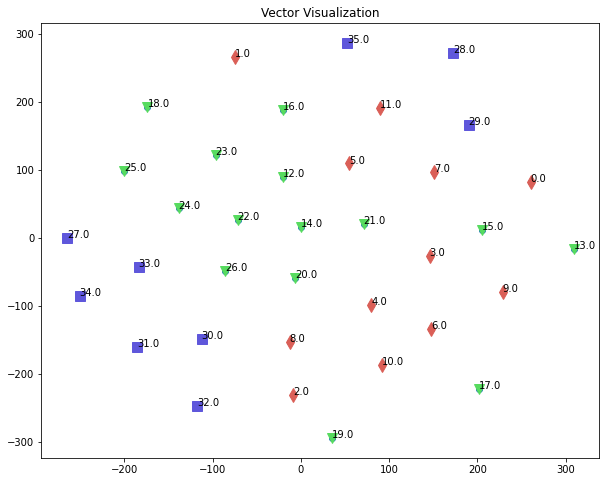

In [58]:
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib.patheffects as PathEffects
%matplotlib inline


colors = X_embedded_df["Categories"]
num_classes = len(np.unique(colors))
labels = X_embedded_df["labels"]
palette = np.array(sn.color_palette("hls", num_classes))
markers =  np.array(["d", "v", "s", "*", "^"])    
f = plt.figure(figsize=(10, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(X_embedded[:,0], X_embedded[:,1])
plt.xlim(-25, 25)
plt.ylim(-25, 25)
ax.axis('tight')

present_category = 0
categories =  X_embedded_df["Categories"].values
for idx in range(len(categories)):
    category = categories[idx]
    if(category == present_category):
        plt.plot(X_embedded[idx][0], X_embedded[idx][1],color = palette[category], marker = markers[category], markersize = 10)
    else:
        present_category = present_category + 1
        plt.plot(X_embedded[idx][0], X_embedded[idx][1],color = palette[category], marker = markers[category], markersize = 10)
        
for i in range(len(labels)):       
    plt.annotate(labels[i], (X_embedded[i][0], X_embedded[i][1] + 0.3))


ax.set_title('Vector Visualization')

**Question:** Comment about the categorizion done by T-SNE. Do the articles of related topics cluster together? (5 points)

**Answer(1-3 sentences):**  
  


The t-SNE algorithm could efficiently project complex data sets onto a 2D plane, while the local structure of the data in the original high-dimensional space is preserved as much as possible.It has mapped our multi-dimensional data spanned across 3 different categories and 36 different topics to two or more dimensions suitable for human observation. With help of the t-SNE algorithms, we manage to visualize fewer exploratory data analysis plots of high dimensional data.
Even if we can understand the patterns in data and present it on simple charts, it is still difficult for anyone without statistics background to make sense of it. Also, if we have hundreds of features, we have to study thousands of charts before we can make sense of this data.With the help of dimensionality reduction algorithm, we are able to present the data explicitly.

My data is spanned across 3 different categories which are Data Analytics, Bank and Games.
Each of these categories have 12 ,15 ,9 different kinds of topics attached to it.
We can see in the above scatter plot that all the similar category data are clustered together with a few exceptions.
For eg:- for plot number 17, the article is "200 West Street" which might be misjudged as a location and has closer 
location to one the univeristy names or the locations of the univeristy. So this article is more closely clustered to Univeristy category cluster.
T-SNE, this non-linear dimensionality reduction algorithm finds patterns in the data by identifying observed clusters based on similarity of data points with multiple features. But it is not a clustering algorithm it is a dimensionality reduction algorithm. This is because it maps the multi-dimensional data to a lower dimensional space, the input features are no longer identifiable. Thus we cannot make any inference based only on the output of t-SNE. So essentially it is mainly a data exploration and visualization technique.
But t-SNE can be used in the process of classification and clustering by using its output as the input feature for other classification algorithms.

# Question 3 Building Neural Networks

### We are gonna use Emotions Dataset for this task. We need to classify the given text into different kind of emotions like happy,sad,anger etc.., 

### We are providing train.txt and val.txt files along with this notebook. 

### Library Imports and Utility functions

In [417]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import pandas as pd
import re
#string.punctuation
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())


def clean_text(text):
  # From the last assignment
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)
        if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text

[nltk_data] Downloading package stopwords to /Users/neo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/neo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /Users/neo/nltk_data...
[nltk_data]   Package words is already up-to-date!


### Q) Importing the datasets and do the necessary cleaning and convert the text into the vectors which are mentioned in the below code blocks. (10 points)

In [418]:
# Import the train.txt and val.txt file into pandas dataframe format 

## Reading the data and removing columns that are not important. 

# train 
train = pd.read_csv("train.txt", sep=";", header=None, names=['text', 'emotion'])
# validation
validation = pd.read_csv("val.txt", sep=";" , header=None, names=['text', 'emotion'])
# and printout the train.shape and validation.shape 
print(train.shape)
print(validation.shape)


(16000, 2)
(2000, 2)


In [419]:
# clean the text in the train and validation dataframes using the clean_text function provided above

text = train['text']
cleaned_text_train = []
for sentence in text:
    sentence = clean_text(sentence)
    cleaned_text_train.append(sentence)
train['text'] = cleaned_text_train  

cleaned_text_val = []

validation_text = validation['text']
for sentence in validation_text:
    sentence = clean_text(sentence)
    cleaned_text_val.append(sentence)
validation['text'] = cleaned_text_val      

In [420]:
# initialise count vectorizer from sklearn module with default parameter
from sklearn.model_selection import train_test_split
vectorizer = CountVectorizer()

# fit on train dataset and transform both train and validation dataset
X = train['text'].values
vectorizer.fit(X)
X_train_count_vector =  vectorizer.transform(X)
print(X_train_count_vector.shape)

val = validation['text'].values
X_val_count_vector = vectorizer.transform(val)
print(X_val_count_vector.shape)


(16000, 13457)
(2000, 13457)


In [421]:
# initialise tfidf vectorizer from sklearn module with default parameter
vectorizer = TfidfVectorizer()

X = train['text'].values
vectorizer.fit(X)
X_train_tfidf_vector =  vectorizer.transform(X)
X_val_tfidf_vector = vectorizer.transform(validation['text'].values)

In [422]:
# initialise label encoder from sklearn module

from sklearn import preprocessing
le = preprocessing.LabelEncoder()


# fit on train labels and transform both train and validation labels

train['emotion'] = le.fit_transform(train['emotion'])
validation['emotion'] = le.transform(validation['emotion'])
train.head()

,text,emotion
0,didnt feel humiliated,4
1,go feeling hopeless damned hopeful around some...,4
2,im grabbing minute post feel greedy wrong,0
3,ever feeling nostalgic fireplace know still pr...,3
4,feeling grouchy,0


In [423]:
# convert the labels into one hot encoding form
from sklearn.preprocessing import OneHotEncoder

onehotencoder = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
onehotencoder_train_df = pd.DataFrame(onehotencoder.fit_transform(train[['emotion']].values))
# # train.drop("emotion", axis=1, inplace=True)
# print(onehotencoder_train_df)
# print(train)
# print(onehotencoder_train_df.columns.intersection(train.columns))
train = train.join(onehotencoder_train_df)
#print(train)
onehotencoder_val_df = pd.DataFrame(onehotencoder.fit_transform(validation[['emotion']]))
#validation = validation.join(onehotencoder_val_df)

#  one_hot_encoded_data_train = pd.get_dummies(train, columns = ['emotion'])
#  print(one_hot_encoded_data_train)
# print(type(one_hot_encoded_data_train))
# print(type(train['emotion']))

# one_hot_encoded_data_val = pd.get_dummies(validation, columns = ['emotion'])

### Q) Build the neural networks using tensorflow keras by following the below instructions. Evaluate the model on different metrics and comment your observations. (15 points)

In [424]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.python.keras import regularizers
import keras
import keras.utils
from keras import utils as np_utils

tf.random.set_seed(42)


# complete this linear model in tensorflow
def build_model(X):

  # layer 1 : input layer
  inp = tf.keras.Input((X.shape[1],))  
  # layer 2 : add the dense layer with 2048 units and relu activation
  x = tf.keras.layers.Dense(2048,input_dim = X.shape[1], activation = "relu")(inp)
  # layer 3 : add the dropout layer with dropout rate of 0.5
  x = tf.keras.layers.Dropout(.5)(x)  
  # layer 4 : add the dense layer with 1024 units with tanh activation and with l2 regularization
  x = tf.keras.layers.Dense(1024, activation = "tanh", kernel_regularizer = regularizers.l2(0.01))(x)
  # layer 5 : add the dropout layer with dropout rate of 0.5
  x = tf.keras.layers.Dropout(.5)(x)  
  # layer 6 : add the dense layer with 512 units with tanh activation and with l2 regularization
  x = tf.keras.layers.Dense(512, activation = "tanh", kernel_regularizer = regularizers.l2(0.01))(x)
  # layer 7 : add the dropout layer with dropout rate of 0.5
  x = tf.keras.layers.Dropout(.5)(x)
  # layer 8 : add the dense layer with 256 units with tanh activation and with l2 regularization
  x = tf.keras.layers.Dense(256, activation = "tanh", kernel_regularizer = regularizers.l2(0.01))(x)
  # layer 9 : add the dropout layer with dropout rate of 0.5
  x = tf.keras.layers.Dropout(.5)(x)
  # layer 10 : add the dense layer with 128 units with tanh activation and with l2 regularization
  x = tf.keras.layers.Dense(128, activation = "tanh", kernel_regularizer = regularizers.l2(0.01))(x)
  # layer 11 : add the dropout layer with dropout rate of 0.5
  x = tf.keras.layers.Dropout(.5)(x)
  # layer 12 : output layer with units equal to number of classes and activation as softmax
  x = tf.keras.layers.Dense(6,activation = 'softmax')(x)     
  model = tf.keras.models.Model(inputs=inp, outputs=x)
  # use loss as categorical crossentropy, optimizer as rmsprop and evaluate model on auc,precision,recall,accuracy 
  model.compile(loss = 'categorical_crossentropy' , optimizer = 'rmsprop', metrics = ["categorical_accuracy",
                                                                                             keras.metrics.Precision(), keras.metrics.Recall(),
                                                                                            tf.keras.metrics.AUC()
                                                                                            ])
  return model


In [425]:
# call the build_model function and initialize the model
model = build_model(X_train_count_vector)
model.summary()


(None, 13457)
(None, 2048)
(None, 2048)
(None, 1024)
(None, 1024)
(None, 512)
(None, 512)
(None, 256)
(None, 256)
(None, 128)
(None, 128)
(None, 6)
(None, 13457)
(None, 6)
Model: "model_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 13457)]           0         
                                                                 
 dense_282 (Dense)           (None, 2048)              27561984  
                                                                 
 dropout_235 (Dropout)       (None, 2048)              0         
                                                                 
 dense_283 (Dense)           (None, 1024)              2098176   
                                                                 
 dropout_236 (Dropout)       (None, 1024)              0         
                                                                 
 dense_284 (Dense)

In [426]:
# train and validate the model on the count vectors of text which we have created initially for 10 epochs, 
# adjust batch size according to your computation power (suggestion use : 8)
from sklearn.metrics import accuracy_score
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='count.h5',
    save_weights_only=True,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy',factor=0.1,patience=3)

history = model.fit(X_train_count_vector.toarray(),onehotencoder_train_df, epochs=10, batch_size = 8,validation_data=(X_val_count_vector.toarray(), onehotencoder_val_df) ,callbacks=[model_checkpoint_callback,lr_schedule] ) 
y_pred = model.predict(X_val_count_vector.toarray())
y_pred = y_pred.argmax(axis = 1)
print(accuracy_score(y_pred,validation['emotion']))


Epoch 1/10
2000/2000 [==============================] - 688s 343ms/step - loss: 2.3445 - categorical_accuracy: 0.4201 - precision_24: 0.5986 - recall_24: 0.1528 - auc_24: 0.7921 - val_loss: 1.3062 - val_categorical_accuracy: 0.5810 - val_precision_24: 0.7935 - val_recall_24: 0.3305 - val_auc_24: 0.8812 - lr: 0.0010
Epoch 2/10
2000/2000 [==============================] - 1603s 802ms/step - loss: 1.3171 - categorical_accuracy: 0.6091 - precision_24: 0.7111 - recall_24: 0.4412 - auc_24: 0.8852 - val_loss: 1.2456 - val_categorical_accuracy: 0.6820 - val_precision_24: 0.7421 - val_recall_24: 0.5640 - val_auc_24: 0.9041 - lr: 0.0010
Epoch 3/10
2000/2000 [==============================] - 2078s 1s/step - loss: 1.2144 - categorical_accuracy: 0.6691 - precision_24: 0.7386 - recall_24: 0.5663 - auc_24: 0.9084 - val_loss: 1.2066 - val_categorical_accuracy: 0.6950 - val_precision_24: 0.7535 - val_recall_24: 0.5715 - val_auc_24: 0.9091 - lr: 0.0010
Epoch 4/10
2000/2000 [============================

dict_keys(['loss', 'categorical_accuracy', 'precision_24', 'recall_24', 'auc_24', 'val_loss', 'val_categorical_accuracy', 'val_precision_24', 'val_recall_24', 'val_auc_24', 'lr'])


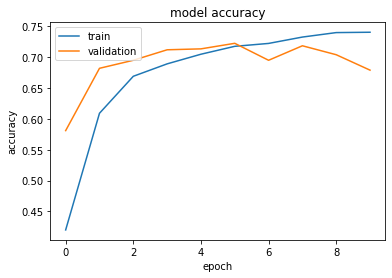

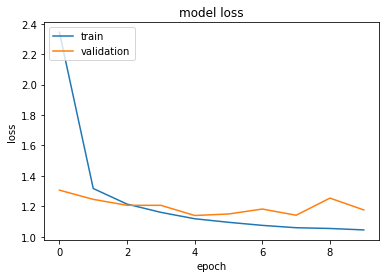

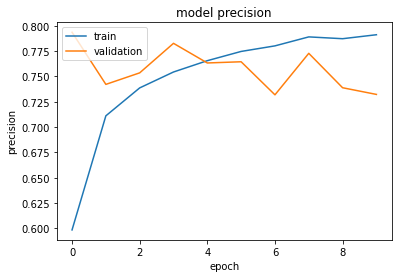

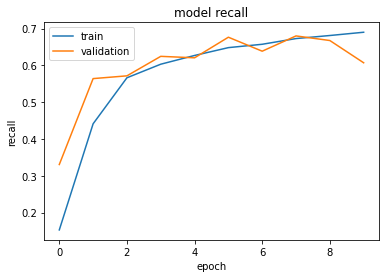

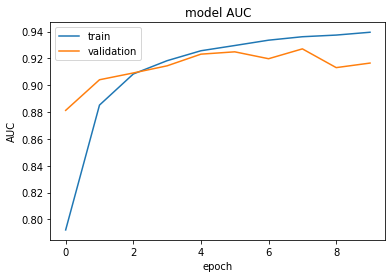

In [427]:
# plot train loss vs val loss, train auc vs val auc, train recall vs val recall,
#train precision vs val precision and train accuracy vs val accuracy and comment your observations

print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Precision"
precision = ''
val_precision = ''
recall = ''
val_recall = ''
AUC = ''
val_AUC = ''
for key in history.history.keys():
    if key.startswith('precision'):
        precision = key
    if key.startswith('val_precision'):
        val_precision = key    
    if key.startswith ('recall'):
        recall = key
    if key.startswith ('val_recall'):
        val_recall = key
    if key.startswith ('auc'):
        AUC = key
    if key.startswith ('val_auc'):
        val_AUC = key    
        
plt.plot(history.history[precision])
plt.plot(history.history[val_precision])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Recall"
plt.plot(history.history[recall])
plt.plot(history.history[val_recall])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "AUC"
plt.plot(history.history[AUC])
plt.plot(history.history[val_AUC])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


##Observations:

** Accuracy:**
The above machine learning model has high training accuracy and slightly low validation accuracy so this is a scenario of over-fitting. The reasons for this:

    The hypothesis function we are using is too complex that our model perfectly fits the training data but fails to do on test/validation data.
    The number of learning parameters in our model is comparatively bigger that instead of generalizing the examples, our model learns some specific examples and hence the model performs badly on test/validation data.

To solve the above problems a number of solutions can be tried depending on our dataset:

    Use a simple cost and loss function.
    Use regulation which helps in reducing over-fitting i.e Dropout.
    Reduce the number of learning parameters in your model.

** Loss:**
Slightly higher validation loss than training loss. This means the model is slightly overfitted.

Our aim is to make the validation loss as low as possible. Some overfitting is nearly always a good thing. Regularization is any technique that aims at making the model generalize better, that produces better results on the test set. We can use Regularization to help us overcome overfitting of the model.

** Precision, Recall, AUC**

High training precision and low validation precision, high training recall and low validation recall, high training AUC and low validation AUC all indicate towards the fact that the model is overfitted.

Fixes:
1)Cross-validation:Cross-validation is a powerful preventative measure against overfitting. We can use our initial training data to generate multiple mini train-test splits. Use these splits to tune your model.

2)Train with more data:It won’t work every time, but training with more data can help algorithms detect the signal better.

3)Remove features:Some algorithms have built-in feature selection. For those that don’t, we can manually improve their generalizability by removing irrelevant input features.

4)Early stopping:For training a learning algorithm iteratively, we can measure how well each iteration of the model performs.Up until a certain number of iterations, new iterations improve the model. After that point, however, the model’s ability to generalize can weaken as it begins to overfit the training data.Early stopping refers stopping the training process before the learner passes that point.

5)Regularization:Regularization refers to a broad range of techniques for artificially forcing our model to be simpler.The method will depend on the type of learner we are using. For example, we could prune a decision tree, use dropout on a neural network, or add a penalty parameter to the cost function in regression.

In [428]:
# again call the build_model function and initialize the model
model = build_model(X_train_tfidf_vector)
model.summary()

(None, 13457)
(None, 2048)
(None, 2048)
(None, 1024)
(None, 1024)
(None, 512)
(None, 512)
(None, 256)
(None, 256)
(None, 128)
(None, 128)
(None, 6)
(None, 13457)
(None, 6)
Model: "model_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, 13457)]           0         
                                                                 
 dense_288 (Dense)           (None, 2048)              27561984  
                                                                 
 dropout_240 (Dropout)       (None, 2048)              0         
                                                                 
 dense_289 (Dense)           (None, 1024)              2098176   
                                                                 
 dropout_241 (Dropout)       (None, 1024)              0         
                                                                 
 dense_290 (Dense)

In [429]:
# train and validate the model on the count vectors of text which we have created initially for 10 epochs, 
# adjust batch size according to your computation power (suggestion use : 8)
from sklearn.metrics import accuracy_score
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tfidfmodel.h5',
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy',factor=0.1,patience=5)
history = model.fit(X_train_tfidf_vector.toarray(),onehotencoder_train_df
                   ,epochs=10, batch_size = 8
                    , validation_data=(X_val_tfidf_vector.toarray(), onehotencoder_val_df)
                                      ,callbacks=[model_checkpoint_callback,lr_schedule])
y_pred = model.predict(X_val_tfidf_vector.toarray())
y_pred = y_pred.argmax(axis = 1)
print(accuracy_score(y_pred,validation['emotion']))


Epoch 1/10
2000/2000 [==============================] - 724s 361ms/step - loss: 1.9696 - categorical_accuracy: 0.3709 - precision_25: 0.4976 - recall_25: 0.0974 - auc_25: 0.7846 - val_loss: 1.3667 - val_categorical_accuracy: 0.4480 - val_precision_25: 0.6548 - val_recall_25: 0.2580 - val_auc_25: 0.8584 - lr: 0.0010
Epoch 2/10
2000/2000 [==============================] - 1417s 709ms/step - loss: 1.3218 - categorical_accuracy: 0.5483 - precision_25: 0.6694 - recall_25: 0.3347 - auc_25: 0.8754 - val_loss: 1.2548 - val_categorical_accuracy: 0.6340 - val_precision_25: 0.7081 - val_recall_25: 0.5360 - val_auc_25: 0.8987 - lr: 0.0010
Epoch 3/10
2000/2000 [==============================] - 799s 399ms/step - loss: 1.2014 - categorical_accuracy: 0.6485 - precision_25: 0.7294 - recall_25: 0.5282 - auc_25: 0.9062 - val_loss: 1.1659 - val_categorical_accuracy: 0.6735 - val_precision_25: 0.7667 - val_recall_25: 0.5275 - val_auc_25: 0.9106 - lr: 0.0010
Epoch 4/10
2000/2000 [==========================

dict_keys(['loss', 'categorical_accuracy', 'precision_25', 'recall_25', 'auc_25', 'val_loss', 'val_categorical_accuracy', 'val_precision_25', 'val_recall_25', 'val_auc_25', 'lr'])


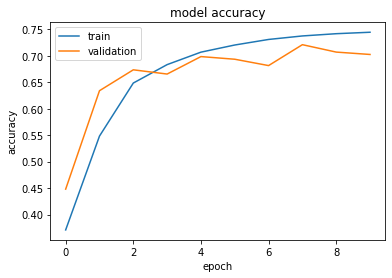

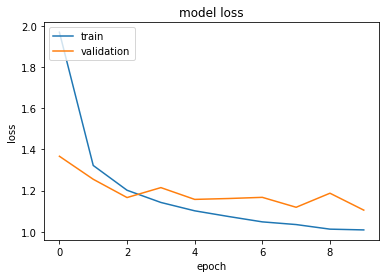

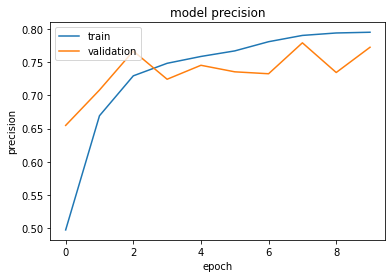

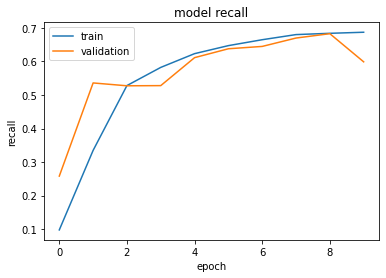

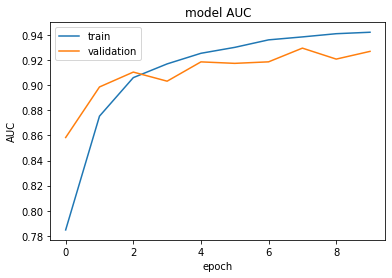

In [430]:
# plot train loss vs val loss, train auc vs val auc, train recall vs val recall,
#train precision vs val precision and train accuracy vs val accuracy and comment your observations

print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Precision"
precision = ''
val_precision = ''
recall = ''
val_recall = ''
AUC = ''
val_AUC = ''
for key in history.history.keys():
    if key.startswith('precision'):
        precision = key
    if key.startswith('val_precision'):
        val_precision = key    
    if key.startswith ('recall'):
        recall = key
    if key.startswith ('val_recall'):
        val_recall = key
    if key.startswith ('auc'):
        AUC = key
    if key.startswith ('val_auc'):
        val_AUC = key    
        
plt.plot(history.history[precision])
plt.plot(history.history[val_precision])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Recall"
plt.plot(history.history[recall])
plt.plot(history.history[val_recall])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "AUC"
plt.plot(history.history[AUC])
plt.plot(history.history[val_AUC])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


##Observations:

** Accuracy:**
The above machine learning model has high training accuracy and slightly low validation accuracy so this is a scenario of over-fitting. The reasons for this:

    The hypothesis function we are using is too complex that our model perfectly fits the training data but fails to do on test/validation data.
    The number of learning parameters in our model is comparatively bigger that instead of generalizing the examples, our model learns some specific examples and hence the model performs badly on test/validation data.

To solve the above problems a number of solutions can be tried depending on our dataset:

    Use a simple cost and loss function.
    Use regulation which helps in reducing over-fitting i.e Dropout.
    Reduce the number of learning parameters in your model.

** Loss:**
Slightly higher validation loss than training loss. This means the model is slightly overfitted.

Our aim is to make the validation loss as low as possible. Some overfitting is nearly always a good thing. Regularization is any technique that aims at making the model generalize better, that produces better results on the test set. We can use Regularization to help us overcome overfitting of the model.

** Precision, Recall, AUC**

High training precision and low validation precision, high training recall and low validation recall, high training AUC and low validation AUC all indicate towards the fact that the model is overfitted.

Fixes:
 1)Cross-validation:Cross-validation is a powerful preventative measure against overfitting. We can use our initial training data to generate multiple mini train-test splits. Use these splits to tune your model.

2)Train with more data:It won’t work every time, but training with more data can help algorithms detect the signal better.

3)Remove features:Some algorithms have built-in feature selection. For those that don’t, we can manually improve their generalizability by removing irrelevant input features.

4)Early stopping:For training a learning algorithm iteratively, we can measure how well each iteration of the model performs.Up until a certain number of iterations, new iterations improve the model. After that point, however, the model’s ability to generalize can weaken as it begins to overfit the training data.Early stopping refers stopping the training process before the learner passes that point.

5)Regularization:Regularization refers to a broad range of techniques for artificially forcing our model to be simpler.The method will depend on the type of learner we are using. For example, we could prune a decision tree, use dropout on a neural network, or add a penalty parameter to the cost function in regression.

## Question 4 Theory Question  

What is the difference between Count Vectorizer, TFIDF, Word2Vec and Glove? (5 points)

**Answer:**

**Differences in the properties of TFIDF, Glove and Word2vec:**
1)Glove and Word2vec are both unsupervised models for generating word vectors. The difference between them is the mechanism of generating word vectors. The word vectors generated by either of these models can be used for a wide variety of tasks ranging such as

    finding words that are semantically similar to a word,
    representing a word when it is being input to a downstream model. A word embedding representation of a word captures more information about a word than just a one-hot representation of the word, since the former captures semantic similarity of that word to other words whereas the latter representation of the word is equidistant from all other words.

Tf-idf is a scoring scheme for words - that is a measure of how important a word is to a document.

From a practical usage standpoint, while tf-idf is a simple scoring scheme and that is its key advantage, word embeddings may be a better choice for most tasks where tf-idf is used, particularly when the task can benefit from the semantic similarity captured by word embeddings (e.g. in information retrieval tasks)

**Differences in the properties of TFIDF and Count Vectorizer:**
2)TfidfVectorizer and CountVectorizer both are methods for converting text data into vectors as model can process only numerical data.

In CountVectorizer we only count the number of times a word appears in the document which results in biasing in favour of most frequent words. this ends up in ignoring rare words which could have helped is in processing our data more efficiently.

To overcome this , we use TfidfVectorizer .

In TfidfVectorizer we consider overall document weightage of a word. It helps us in dealing with most frequent words. Using it we can penalize them. TfidfVectorizer weights the word counts by a measure of how often they appear in the documents.

**Differences in the properties of word2vec and glove:**
3)The two models differ in the way they are trained, and hence lead to word vectors with subtly different properties. Glove model is based on leveraging global word to word co-occurance counts leveraging the entire corpus. Word2vec on the other hand leverages co-occurance within local context (neighbouring words).

In practice, however, both these models give similar results for many tasks. Factors such as the dataset on which these models are trained, length of the vectors and so on seem to have a bigger impact than the models themselves. For instance, if I am using these models to derive  the features for a medical application, I can significantly improve performance by training on dataset from the medical domain.

**Glove model training:**
Glove is based on matrix factorization techniques on the word-context matrix. It first constructs a large matrix of (words x context) co-occurrence information, i.e. for each “word” (the rows), you count how frequently we see this word in some “context” (the columns) in a large corpus.  The number of “contexts” is of course large, since it is essentially combinatorial in size.

So then we factorize this matrix to yield a lower-dimensional (word x features) matrix, where each row now yields a vector representation for the corresponding word. In general, this is done by minimizing a “reconstruction loss”. This loss tries to find the lower-dimensional representations which can explain most of the variance in the high-dimensional data.

**word2vec model training:**
Word2Vec is a feed forward neural network based model to find word embeddings. There are two models that are commonly used to train these embeddings: The skip-gram and the CBOW model. 

The Skip-gram model takes the input as each word in the corpus, sends them to a hidden layer (embedding layer) and from there it predicts the context words. Once trained, the embedding for a particular word is obtained by feeding the word as input and taking the hidden layer value as the final embedding vector. 

The CBOW (Continuous Bag of Words) model takes the input the context words for the given word, sends them to a hidden layer (embedding layer) and from there it predicts the original word. Once again, after training, the embedding for a particular word is obtained by feeding the word as input and taking the hidden layer value as the final embedding vector. 




What is the significant difference between the Niave Bayes Implementation using Bag of Words and TF-IDF? (5 points)

**Answer:**

Drawbacks of using a Bag-of-Words (BoW) Model

If the new sentences contain new words, then our vocabulary size would increase and thereby, the length of the vectors would increase too.
Additionally, the vectors would also contain many 0s, thereby resulting in a sparse matrix (which is what we would like to avoid)
We are retaining no information on the grammar of the sentences nor on the ordering of the words in the text.

Property of TFIDF:
    
TF-IDF gives larger values for less frequent words and is high when both IDF and TF values are high i.e the word is rare in 
all the documents combined but frequent in a single document.

In a nutshell:
Bag of Words just creates a set of vectors containing the count of word occurrences in the document (reviews), 
while the TF-IDF model contains information on the more important words and the less important ones as well.
Bag of Words vectors are easy to interpret. However, TF-IDF usually performs better in machine learning models.
